In [13]:
import pandas as pd
import numpy as np

# To Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns

# To Train our data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import sys
import warnings

warnings.filterwarnings('ignore')

In [14]:
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP
from models import ML_Models

mlp = MLP()
mlm = ML_Models()

In [15]:
fb_data =  pd.read_csv('../data/facebook_data.csv')
ch_data =  pd.read_csv('../data/chrome_data.csv')
cm_data =  pd.read_csv('../data/chrome_mobile_webview_data.csv')
pt5_data =  pd.read_csv('../data/platform_5.csv')
pt6_data =  pd.read_csv('../data/platform_6.csv')

In [16]:

# separating categorical and numerical variables

cat2, num2 = mlp.sep_cat_num(fb_data)
cat3, num3 = mlp.sep_cat_num(ch_data)
cat4, num4 = mlp.sep_cat_num(cm_data)
cat5, num5 = mlp.sep_cat_num(pt5_data)
cat6, num6 = mlp.sep_cat_num(pt6_data)

In [17]:
def processor_pipe(categories):
    pipe_1 = Pipeline(
        steps=[
            ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": categories})),
            ("scale data", FunctionTransformer(mlp.scaler)),
            ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 5], "t":-1})),
            ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
            ])
    return pipe_1

pipe_1 = processor_pipe(cat2)
pipe_2 = processor_pipe(cat5)

sets = pipe_1.fit_transform(fb_data)


catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [18]:
sets2 = pipe_1.fit_transform(ch_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [19]:

sets3 = pipe_1.fit_transform(cm_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [20]:

sets4 = pipe_2.fit_transform(pt5_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [21]:

sets5 = pipe_2.fit_transform(pt6_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [ ]:
model = XGBClassifier(
        learning_rate =0.08,
        n_estimators=1000,
        eval_metric='rmse',
        )
kfold_validation=KFold(5)

In [ ]:
def coross_val_score(data, kfold, f_r, t):
    X = data.iloc[:,:6]
    y = data.iloc[:,-1]
    results=cross_val_score(model,X,y,cv=kfold_validation)
    name = namestr(clean_data,globals())
    print(f'Result of {name[0]}\n')
    print(results)
    print(np.mean(results),'\n')
    print('#################################')
    print('\n')
  

In [22]:
# generate model

model = mlm.xgb_model(sets[0], sets[1], sets[2], sets[3])
model2 = mlm.xgb_model(sets2[0], sets2[1], sets2[2], sets2[3])
model3 = mlm.xgb_model(sets3[0], sets3[1], sets3[2], sets3[3])
model4 = mlm.xgb_model(sets4[0], sets4[1], sets4[2], sets4[3])
model5 = mlm.xgb_model(sets5[0], sets5[1], sets5[2], sets5[3])



The model accuracy is:  0.625
the loss function is:  binary:logistic


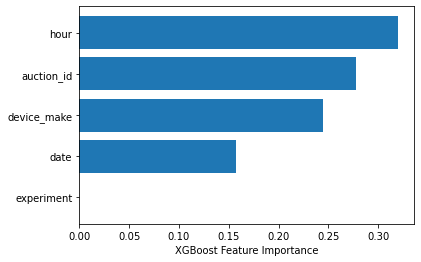

In [24]:
mlm.evaluate_model(model, fb_data, sets[2], sets[3], "XGBoost")

The model accuracy is:  0.4714285714285714
the loss function is:  binary:logistic


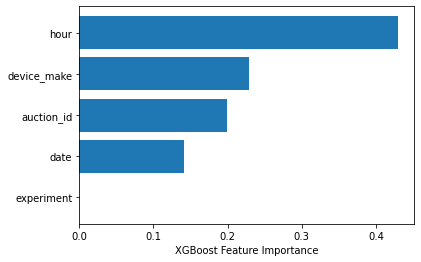

In [25]:
mlm.evaluate_model(model2, ch_data, sets2[2], sets2[3], "XGBoost")

The model accuracy is:  0.5652173913043478
the loss function is:  binary:logistic


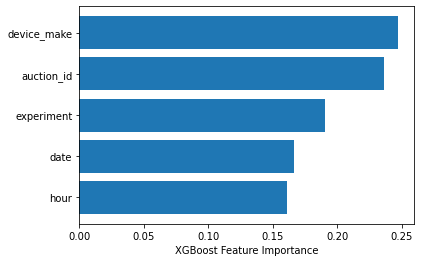

In [26]:
mlm.evaluate_model(model3, cm_data, sets3[2], sets3[3], "XGBoost")

The model accuracy is:  0.6178861788617886
the loss function is:  binary:logistic


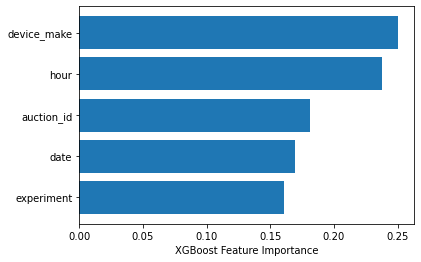

In [27]:
mlm.evaluate_model(model4, pt5_data, sets4[2], sets4[3], "XGBoost")

The model accuracy is:  0.5
the loss function is:  binary:logistic


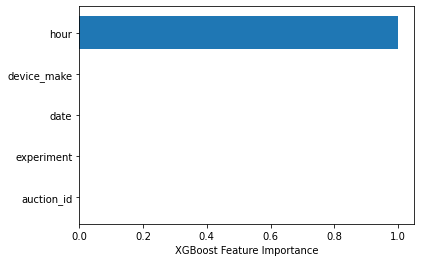

In [28]:
mlm.evaluate_model(model5, pt6_data, sets5[2], sets5[3], "XGBoost")